# 0x05 Gradient descent and backpropagation

In this tutorial we will cover the implementations and how-tos for interacting
with the backpropagation engine of PyTorch.

PyTorch is the go-to library for deep learning in Python especially if you are building a custom model on your own.
You will be very likely be using PyTorch when you are doing your research.

> 💡 **NOTE**: 
>
> We assume you have already learnt the fundamentals of derivatives and gradients.
>
> If you need a quick recap, check out this explanation [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#optional-reading-vector-calculus-using-autograd) by the PyTorch team.
>
> Another suggested deep walkthrough is this [3blue1brown video](https://www.youtube.com/watch?v=tIeHLnjs5U8) on the topic.

## 1. Backpropagation

One of PyTorch tensors' biggest difference with NumPy arrays is that they can track gradients.

Two important ways to interact with it are `requires_grad` and the `.grad` property.
Let us see it with a simple example.

Consider this formula:
$$
y = w_1x^2 + w_2x + b
$$

where $x$ is the input.

> 🤔 **THINKING**
>
> - What is $\frac{\partial y}{\partial w_1}$, $\frac{\partial y}{\partial w_2}$, $\frac{\partial y}{\partial b}$? Compute by hand.

To prove your computation, let us implement this formula in PyTorch.

In [1]:
import torch

x = torch.tensor([2.0])

# Identify the parameters that you need to compute gradients for
# and set requires_grad=True
w1 = torch.tensor([1.0], requires_grad=True)
w2 = torch.tensor([3.0], requires_grad=True)
b = torch.tensor([4.0], requires_grad=True)
# You will see why we used an intermediate variable z here.
z = w1 * torch.pow(x, 2) + w2 * x
y = z + b
print(y)

tensor([14.], grad_fn=<AddBackward0>)


In [2]:
# Compute backpropagation
y.backward()

In [3]:
# Gradient w.r.t. w1, w2, and b are stored in .grad of the tensors
print(w1.grad)  # dy/dw1
print(w2.grad)  # dy/dw2
print(b.grad)  # dy/db

tensor([4.])
tensor([2.])
tensor([1.])


Is your computation correct?

Now, you may want to also get $\frac{dy}{dz}$ from PyTorch.

In [4]:
print(z.grad)  # dy/dz

None


/var/folders/7w/nb0jf_fx2xq3ysf1t9kyrt4w0000gn/T/ipykernel_85138/385971827.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(z.grad)  # dy/dz


Oh no 😱, we cannot do it!

This is because PyTorch does not update the gradients on **non-leaf** tensors. This makes sense because model parameters are leaf tensors. If you really **DO** want to compute the gradients of non-leaf tensors for specific use cases, you can use [`.retain_grad()`](https://pytorch.org/docs/stable/generated/torch.Tensor.retain_grad.html).

> 📚 **EXERCISE**
>
> - Define an expression on your own and get the gradients using backpropagation.
> - Currently, our `y` is a scalar. Although loss is usually scalar in deep learning, what if we have a vector as `y`? How do we compute the gradients in this case?

In [5]:
# === Your code here ===

## 2. Toggling gradient tracking

When you are evaluating a model, you do not need to update the weights, and hence you do not need to track the gradients.

Disabling gradient tracking helps reduce memory consumption and accelerate computations.

In PyTorch, we use `torch.no_grad()` to disable gradient tracking.

In [6]:
import torchvision

resnet = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)
x = torch.randn(1, 3, 224, 224)  # batch size 1, 3 channels, 224x224 image
with torch.no_grad():
    y = resnet(x)
print(y.shape)  # 1000 classes

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/louishhy/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.57MB/s]


torch.Size([1, 1000])


> You may also notice that there is a `torch.eval()` method in PyTorch. It is different from `torch.no_grad()`. `eval()` is used to set the model in evaluation mode and it is mainly used for batch normalization and dropout layers. You will learn more about it in the following chapters.

## 3. Gradient descent and optimizing process

You might already be using PyTorch optimizers to finetune your models. 

Optimizers update the model parameters using the gradients computed by backpropagation, and determines update process using certain algorithms.

Today, we will use a simple example to show what is happening during the optimization process.

To make the demonstration clear, suppose we have an EXTREMELY simple model, mapping a 3D vector to a scalar:
$$
y = w^Tx + b, x \in \mathbb{R}^3, w \in \mathbb{R}^3, b \in \mathbb{R}
$$

In [7]:
# We need gradient tracking for the parameters
w = torch.ones(size=(3,), requires_grad=True)
b = torch.ones(size=(1,), requires_grad=True)
print(f"w: {w}, b: {b}")

w: tensor([1., 1., 1.], requires_grad=True), b: tensor([1.], requires_grad=True)


In PyTorch, the optimizers are implemented in the `torch.optim` module.

Here we will use the `SGD` optimizer, which implements the stochastic gradient descent algorithm. It's basic form is given by:
$$
w = w - \eta \frac{\partial L}{\partial w}
$$
where $\eta$ is the learning rate and $L$ is the loss function.

In [8]:
optimizer = torch.optim.SGD([w, b], lr=0.01)

Let's see it in action by supposing that we have a single input to this model.

In [9]:
x = torch.tensor([2.0, 3.0, 4.0])
y = torch.dot(w, x) + b
print(f"y: {y}")

y: tensor([10.], grad_fn=<AddBackward0>)


Suppose that, our dataset tell us that the ground-truth is $y = 2$ and we define our loss function as the squared error:
$$
L = \frac{1}{2}(y - y_{pred})^2
$$
where $y_{pred}$ is the output of our model, $y$ is the ground-truth.

> 🤔 **THINKING**
>
> - Work out $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$ by hand.
> - Based on your computation, why do we have a factor of $\frac{1}{2}$ in the loss function?

In [10]:
# Calculate the loss
gt = torch.tensor([2.0])
loss = 0.5 * torch.pow(gt - y, 2)
print(f"loss: {loss}")

loss: tensor([32.], grad_fn=<MulBackward0>)


In [11]:
# Get the gradients
loss.backward()
print(f"w.grad: {w.grad}, w: {w}")
print(f"b.grad: {b.grad}, b: {b}")

w.grad: tensor([16., 24., 32.]), w: tensor([1., 1., 1.], requires_grad=True)
b.grad: tensor([8.]), b: tensor([1.], requires_grad=True)


We step once through the optimization process and see how the model parameters are updated.

In [12]:
optimizer.step()

In [13]:
print(f"w.grad: {w.grad}, w: {w}")
print(f"b.grad: {b.grad}, b: {b}")

w.grad: tensor([16., 24., 32.]), w: tensor([0.8400, 0.7600, 0.6800], requires_grad=True)
b.grad: tensor([8.]), b: tensor([0.9200], requires_grad=True)


> 🤔 **THINKING**
>
> Did your hand-computation match the PyTorch output?

## 4. Momentum

We have seen how "vanilla" SGD works in the previous section. Over the years, many improvements have been proposed to the SGD algorithm. One of them is called **momentum**. 

Just like in physics, momentum is done by adding a fraction of the previous update ("velocity") to the current one.
$$
v_t = \frac{\partial L}{\partial w} + \mu v_{t-1},
\\
w = w - \eta v_t
$$
where $\mu$ is the momentum coefficient, $v_{t-1}$ is the previous update "velocity", and $\eta$ is the learning rate.

How about we try it out in practice? We will use the same model as before, but this time we will add momentum to the SGD optimizer.

In [14]:
# Prepare two datapoint to simulate two updates
x_seq = torch.tensor([2.0, 3.0, 4.0]), torch.tensor([3.0, 2.0, -5.0])
gt_seq = torch.tensor([2.0]), torch.tensor([5.0])

In [15]:
# Normal gradient descent
w_sgd = torch.ones(size=(3,), requires_grad=True)
b_sgd = torch.ones(size=(1,), requires_grad=True)
optim_sgd = torch.optim.SGD([w_sgd, b_sgd], lr=0.01)
sgd_record = [(w_sgd.clone(), b_sgd.clone())]
for i in range(2):
    x = x_seq[i]
    gt = gt_seq[i]
    y = torch.dot(w_sgd, x) + b_sgd
    loss = 0.5 * torch.pow(gt - y, 2)
    loss.backward()
    optim_sgd.step()
    optim_sgd.zero_grad()
    sgd_record.append((w_sgd.clone(), b_sgd.clone()))

In [16]:
# Retrieve the diff
diff_w_sgd = [
    sgd_record[i][0] - sgd_record[i + 1][0] for i in range(len(sgd_record) - 1)
]
print(f"diff_w_sgd: {diff_w_sgd}")

diff_w_sgd: [tensor([0.1600, 0.2400, 0.3200], grad_fn=<SubBackward0>), tensor([-0.1032, -0.0688,  0.1720], grad_fn=<SubBackward0>)]


In [17]:
# SGD with momentum
w_momentum = torch.ones(size=(3,), requires_grad=True)
b_momentum = torch.ones(size=(1,), requires_grad=True)
optim_momentum = torch.optim.SGD([w_momentum, b_momentum], lr=0.01, momentum=0.9)
momentum_record = [(w_momentum.clone(), b_momentum.clone())]

for i in range(2):
    x = x_seq[i]
    gt = gt_seq[i]
    y = torch.dot(w_momentum, x) + b_momentum
    loss = 0.5 * torch.pow(gt - y, 2)
    loss.backward()
    optim_momentum.step()
    optim_momentum.zero_grad()
    momentum_record.append((w_momentum.clone(), b_momentum.clone()))

# Retrieve the diff
diff_w_momentum = [
    momentum_record[i][0] - momentum_record[i + 1][0]
    for i in range(len(momentum_record) - 1)
]
print(f"diff_w_momentum: {diff_w_momentum}")

diff_w_momentum: [tensor([0.1600, 0.2400, 0.3200], grad_fn=<SubBackward0>), tensor([0.0408, 0.1472, 0.4600], grad_fn=<SubBackward0>)]


In [18]:
# Don't forget to detach the tensors before visualizing them
diff_w_sgd = [diff_w.detach().numpy() for diff_w in diff_w_sgd]  # type: ignore
diff_w_momentum = [diff_w.detach().numpy() for diff_w in diff_w_momentum]  # type: ignore

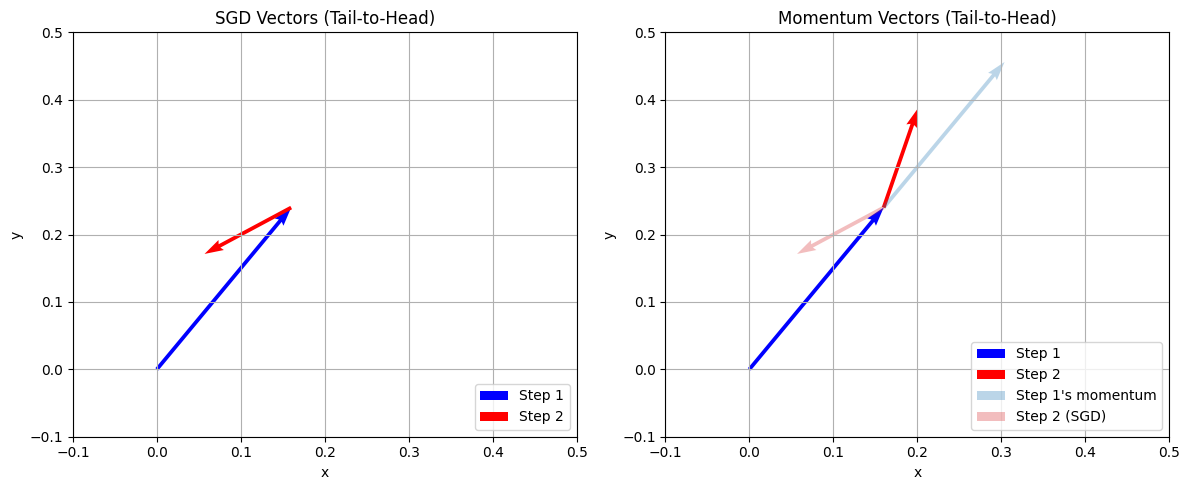

In [19]:
import matplotlib.pyplot as plt

x_lim = (-0.1, 0.5)
y_lim = (-0.1, 0.5)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot SGD vectors tail-to-head for the first two features
ax1.quiver(
    0,
    0,
    diff_w_sgd[0][0],
    diff_w_sgd[0][1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="blue",
    label="Step 1",
)
ax1.quiver(
    diff_w_sgd[0][0],
    diff_w_sgd[0][1],
    diff_w_sgd[1][0],
    diff_w_sgd[1][1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="red",
    label="Step 2",
)
ax1.set_xlim(*x_lim)
ax1.set_ylim(*y_lim)
ax1.grid(True)
ax1.set_title("SGD Vectors (Tail-to-Head)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend(loc="lower right")

# Plot Momentum vectors tail-to-head
ax2.quiver(
    0,
    0,
    diff_w_momentum[0][0],
    diff_w_momentum[0][1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="blue",
    label="Step 1",
)
ax2.quiver(
    diff_w_momentum[0][0],
    diff_w_momentum[0][1],
    diff_w_momentum[1][0],
    diff_w_momentum[1][1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="red",
    label="Step 2",
)
ax2.quiver(
    diff_w_momentum[0][0],
    diff_w_momentum[0][1],
    0.9 * diff_w_momentum[0][0],
    0.9 * diff_w_momentum[0][1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="tab:blue",
    label="Step 1's momentum",
    alpha=0.3,
)
ax2.quiver(
    diff_w_sgd[0][0],
    diff_w_sgd[0][1],
    diff_w_sgd[1][0],
    diff_w_sgd[1][1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="tab:red",
    label="Step 2 (SGD)",
    alpha=0.3,
)
ax2.set_xlim(*x_lim)
ax2.set_ylim(*y_lim)
ax2.grid(True)
ax2.set_title("Momentum Vectors (Tail-to-Head)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

You can observe that, the momentum "pulls" the original update vector closer to the previous update.

Think of this process as navigating on the error function landscape, where you have a tendency to keep your original direction rather than relying solely on observing the slopes around you.

Because of this characteristic, momentum is important in deep learning as it:
1. Helps to accelerate the convergence of the model on plateaus, since the original update vector may be small (the slope is small).
2. Helps escape local minima, especially in non-convex optimization problems (which is usually the case in deep learning).

> 📚 **EXERCISE**
>
> - Except the `SGD` optimizer, there are also other optimizers in PyTorch. 
> For example, `Adam` is a very popular optimizer in deep learning.
> Learn about them and try to implement them in the optimization process.

In [20]:
# === Your code here ===